(Chapter 6: Stochastic Discounting)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 6: Stochastic Discounting


```{contents} Contents
:depth: 2
```

In [1]:
using Pkg;
Pkg.activate("./");

  Activating project at `D:\GitHub\dp_text_1\code_book\jl`


## plot_interest_rates.jl

In [2]:
# Nominal interest rate from https://fred.stlouisfed.org/series/GS1
# Real interest rate from https://fred.stlouisfed.org/series/WFII10
#
# Download as CSV files using download_interest_rates.jl
#

using DataFrames, CSV, PyPlot

df_nominal = DataFrame(CSV.File("data/GS1.csv"))
df_real = DataFrame(CSV.File("data/WFII10.csv"))

function plot_rates(df; fontsize=16, savefig=true)
    r_type = df == df_nominal ? "nominal" : "real"
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(df[!, 1], df[!, 2], label=r_type*" interest rate")
    ax.plot(df[!, 1], zero(df[!, 2]), c="k", ls="--")
    ax.set_xlim(df[1, 1], df[end, 1])
    ax.legend(fontsize=fontsize, frameon=false)
    if savefig
        fig.savefig("../figures/plot_interest_rates_"*r_type*".pdf")
    end
end


plot_rates (generic function with 1 method)

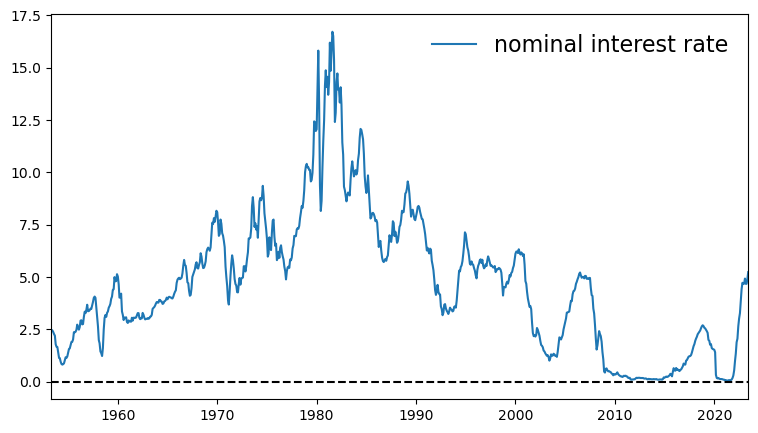

In [3]:
plot_rates(df_nominal, savefig=true)

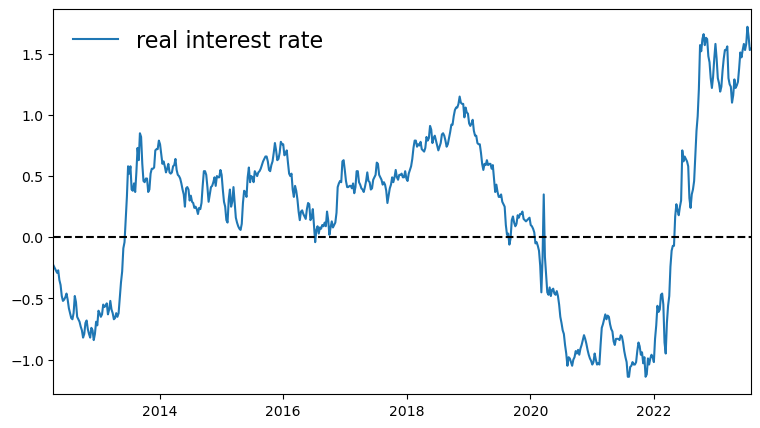

In [4]:
plot_rates(df_real, savefig=true)

## pd_ratio.jl

In [5]:
"""
Price-dividend ratio in a model with dividend and consumption growth.

"""

using QuantEcon, LinearAlgebra

"Creates an instance of the asset pricing model with Markov state."
function create_asset_pricing_model(;
        n=200,              # state grid size
        ρ=0.9, ν=0.2,       # state persistence and volatility
        β=0.99, γ=2.5,      # discount and preference parameter
        μ_c=0.01, σ_c=0.02, # consumption growth mean and volatility
        μ_d=0.02, σ_d=0.1)  # dividend growth mean and volatility
    mc = tauchen(n, ρ, ν)
    x_vals, P = exp.(mc.state_values), mc.p
    return (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d)
end

" Build the discount matrix A. "
function build_discount_matrix(model)
    (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
    e = exp.(μ_d - γ*μ_c + (γ^2*σ_c^2 + σ_d^2)/2 .+ (1-γ)*x_vals)
    return β * e .* P
end

"Compute the price-dividend ratio associated with the model."
function pd_ratio(model)
    (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
    A = build_discount_matrix(model)
    @assert maximum(abs.(eigvals(A))) < 1 "Requires r(A) < 1."
    n = length(x_vals)
    return (I - A) \ (A * ones(n))
end


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

default_model = create_asset_pricing_model()


function plot_main(; μ_d_vals = (0.02, 0.08),
                     savefig=false, 
                     figname="../figures/pd_ratio_1.pdf")
    fig, ax = plt.subplots(figsize=(9, 5.2))

    for μ_d in μ_d_vals
        model = create_asset_pricing_model(μ_d=μ_d)
        (; x_vals, P, β, γ, μ_c, σ_c, μ_d, σ_d) = model
        v_star = pd_ratio(model)
        ax.plot(x_vals, v_star, lw=2, alpha=0.6, label=L"\mu_d="*"$μ_d")
    end

    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"x", fontsize=fontsize)
    if savefig
        fig.savefig(figname)
    end
end



plot_main (generic function with 1 method)

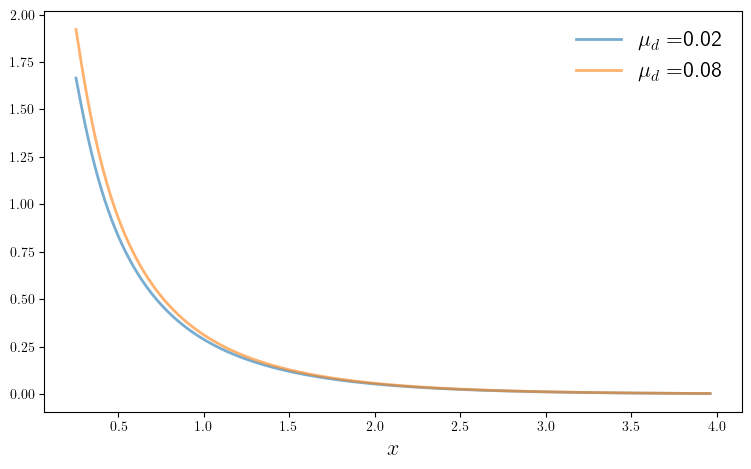

In [6]:
plot_main(savefig=true)

## inventory_sdd.jl

In [7]:
"""
Inventory management model with state-dependent discounting.  
The discount factor takes the form β_t = Z_t, where (Z_t) is 
a discretization of the Gaussian AR(1) process 

    X_t = ρ X_{t-1} + b + ν W_t.

"""

include("s_approx.jl")
using LinearAlgebra, Random, Distributions, QuantEcon

f(y, a, d) = max(y - d, 0) + a  # Inventory update

function create_sdd_inventory_model(; 
            ρ=0.98, ν=0.002, n_z=20, b=0.97,  # Z state parameters
            K=40, c=0.2, κ=0.8, p=0.6,        # firm and demand parameters
            d_max=100)                        # truncation of demand shock

    ϕ(d) = (1 - p)^d * p                      # demand pdf
    d_vals = collect(0:d_max)
    ϕ_vals = ϕ.(d_vals)
    y_vals = collect(0:K)                     # inventory levels
    n_y = length(y_vals)
    mc = tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values .+ b, mc.p
    ρL = maximum(abs.(eigvals(z_vals .* Q)))     
    @assert  ρL < 1 "Error: ρ(L) ≥ 1."    

    R = zeros(n_y, n_y, n_y)
    for (i_y, y) in enumerate(y_vals)
        for (i_y′, y′) in enumerate(y_vals)
            for (i_a, a) in enumerate(0:(K - y))
                hits = f.(y, a, d_vals) .== y′
                R[i_y, i_a, i_y′] = dot(hits, ϕ_vals)
            end
        end
    end

    r = fill(-Inf, n_y, n_y)
    for (i_y, y) in enumerate(y_vals)
        for (i_a, a) in enumerate(0:(K - y))
                cost = c * a + κ * (a > 0)
                r[i_y, i_a] = dot(min.(y, d_vals),  ϕ_vals) - cost
        end
    end

    return (; K, c, κ, p, r, R, y_vals, z_vals, Q)
end

"""
The function 
    B(y, a, v) = r(y, a) + β(z) Σ_{d, z′} v(f(y, a, d), z′) ϕ(d) Q(z, z′)

"""
function B(i_y, i_z, i_a, v, model; d_max=100)
    (; K, c, κ, p, r, R, y_vals, z_vals, Q) = model
    β = z_vals[i_z]
    cv = 0.0
    for i_z′ in eachindex(z_vals)
        for i_y′ in eachindex(y_vals)
            cv += v[i_y′, i_z′] * R[i_y, i_a, i_y′] * Q[i_z, i_z′]
        end
    end
    return r[i_y, i_a] + β * cv
end

"The Bellman operator."
function T(v, model)
    (; K, c, κ, p, r, R, y_vals, z_vals, Q) = model
    new_v = similar(v)
    for i_z in eachindex(z_vals)
        for (i_y, y) in enumerate(y_vals)
            Γy = 1:(K - y + 1)
            new_v[i_y, i_z], _ = findmax(B(i_y, i_z, i_a, v, model) for i_a in Γy)
        end
    end
    return new_v
end

"The policy operator."
function T_σ(v, σ, model)
    (; K, c, κ, p, r, R, y_vals, z_vals, Q) = model
    new_v = similar(v)
    for (i_z, z) in enumerate(z_vals)
        for (i_y, y) in enumerate(y_vals)
            new_v[i_y, i_z] = B(i_y, i_z, σ[i_y, i_z], v, model) 
        end
    end
    return new_v
end


"Get a v-greedy policy.  Returns indices of choices."
function get_greedy(v, model)
    (; K, c, κ, p, r, R, y_vals, z_vals, Q) = model
    n_z = length(z_vals)
    σ_star = zeros(Int32, K+1, n_z)
    for (i_z, z) in enumerate(z_vals)
        for (i_y, y) in enumerate(y_vals)
            Γy = 1:(K - y + 1)
            _, i_a = findmax(B(i_y, i_z, i_a, v, model) for i_a in Γy)
            σ_star[i_y, i_z] = Γy[i_a]
        end
    end
    return σ_star
end


"Approximate lifetime value of policy σ."
function get_value(v_init, σ, m, model)
    v = v_init
    for i in 1:m
        v = T_σ(v, σ, model)
    end
    return v
end

"Use successive_approx to get v_star and then compute greedy."
function value_function_iteration(v_init, model)
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end


"Optimistic policy iteration routine."
function optimistic_policy_iteration(v_init, 
                                     model; 
                                     tolerance=1e-6, 
                                     max_iter=1_000,
                                     print_step=10,
                                     m=60)
    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance && k < max_iter
        last_v = v
        σ = get_greedy(v, model)
        v = get_value(v, σ, m, model)
        error = maximum(abs.(v - last_v))
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        k += 1
    end
    return v, get_greedy(v, model)
end



# == Plots == # 

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

# Create an instance of the model and solve it
println("Create model instance.")
@time model = create_sdd_inventory_model()

(; K, c, κ, p, r, R, y_vals, z_vals, Q) = model
n_z = length(z_vals)
v_init = zeros(Float64, K+1, n_z)

println("Solving model.")
@time v_star, σ_star = optimistic_policy_iteration(v_init, model)
#@time v_star_vfi, σ_star_vfi = value_function_iteration(v_init, model)
z_mc = MarkovChain(Q, z_vals)

"Simulate given the optimal policy."
function sim_inventories(ts_length; X_init=0, seed=500)
    Random.seed!(seed) 
    i_z = simulate_indices(z_mc, ts_length, init=1)
    G = Geometric(p)
    X = zeros(Int32, ts_length)
    X[1] = X_init
    for t in 1:(ts_length-1)
        D′ = rand(G)
        x_index = X[t] + 1
        a = σ_star[x_index, i_z[t]] - 1
        X[t+1] = f(X[t],  a,  D′)
    end
    return X, z_vals[i_z]
end

function plot_ts(; ts_length=400,
                   fontsize=16, 
                   figname="../figures/inventory_sdd_ts.pdf",
                   savefig=false)
    X, Z = sim_inventories(ts_length)
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))

    ax = axes[1]
    ax.plot(X, label="inventory", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, maximum(X)+3)

    # calculate interest rate from discount factors
    r = (1 ./ Z) .- 1

    ax = axes[2]
    ax.plot(r, label=L"r_t", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    #ax.set_ylim(0, maximum(X)+8)

    plt.tight_layout()
    if savefig == true
        fig.savefig(figname)
    end
end

function plot_timing(; m_vals=collect(range(1, 400, step=10)),
                       fontsize=16,
                       savefig=false)
    println("Running value function iteration.")
    vfi_time = @elapsed _ = value_function_iteration(v_init, model)
    println("VFI completed in $vfi_time seconds.")
    opi_times = []
    for m in m_vals
        println("Running optimistic policy iteration with m=$m.")
        opi_time = @elapsed σ_opi = optimistic_policy_iteration(v_init, model, m=m)
        println("OPI with m=$m completed in $opi_time seconds.")
        push!(opi_times, opi_time)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, fill(vfi_time, length(m_vals)), 
            lw=2, label="value function iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_xlabel(L"m", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    if savefig
        fig.savefig("../figures/inventory_sdd_timing.pdf")
    end
    return (pi_time, vfi_time, opi_times)
end


Create model instance.
  0.011390 seconds (71.50 k allocations: 5.095 MiB)
Solving model.


Completed iteration 10 with error 0.0013695502548927152.


  1.371783 seconds (657.61 k allocations: 50.612 MiB, 2.50% gc time, 33.84% compilation time)


plot_timing (generic function with 1 method)

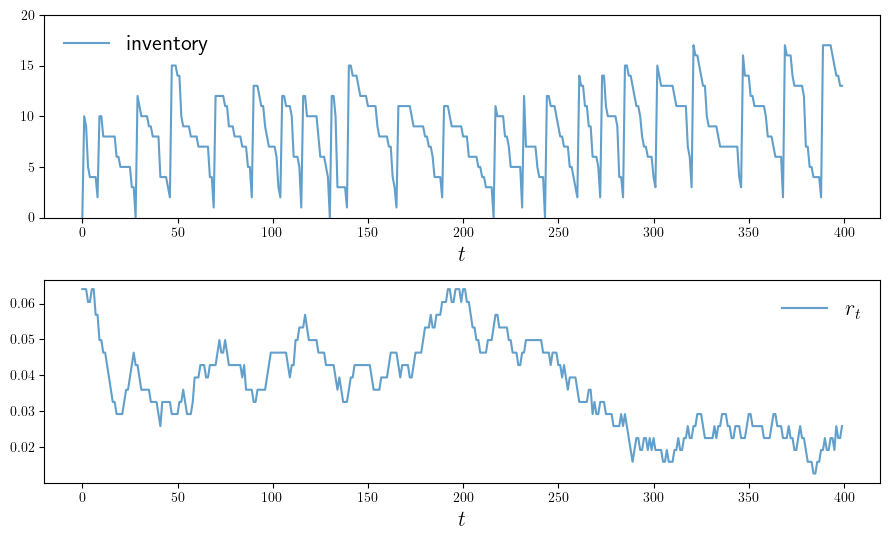

In [8]:
plot_ts(savefig=true)